# Seinfeld TV Script Generator

## Introduction

In this project, we will generate our own [Seinfeld](https://en.wikipedia.org/wiki/Seinfeld) TV scripts using recurrent neural networks (RNNs). We will be using part of the [Seinfeld dataset](https://www.kaggle.com/thec03u5/seinfeld-chronicles#scripts.csv) of scripts from its 9 seasons, and the neural network we will build will generate a new,"fake" TV script, based on patterns it recognizes in this training data.

<img src='images/seinfeld_logo.png'>

As a technical prerequisite, to perform that, first, we need to make some imports:

In [1]:
# Needed imports:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seinfeld_unittests as tests
import helper, os, time, torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from torch.nn.functional import softmax
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
from workspace_utils import active_session

## Get the data

The data is already provided in `data/seinfeld_scripts.txt`: As a first step, we will load in this data and look at some samples, afterward, we will define and train an RNN to generate a new script!

In [2]:
# load in data:
data_dir = 'data/seinfeld_scripts.txt'
text = helper.load_data(data_dir)

## Explore the data

Now, we are going to play around with `view_line_range` to view different parts of the data. This will give us a sense of the data we will be working with.

As we are going to see, for example, the data is all lowercase text, and each new line of dialogue is separated by a newline character `\n`.

In [3]:
# Some stats on the dataset:

print("*** Dataset Stats:\n")
print("Roughly the number of unique words: {}".format(len({word: None for word in text.split()})))
lines = text.split('\n')
print("Number of lines: {}".format(len(lines)))
word_count_line = [len(line.split()) for line in lines]
print("Average number of words in each line: {}\n".format(int(round(np.average(word_count_line)))))

# Display a sample of the dataset:

print("*** Dataset Sample:\n")
view_line_range = (0, 15)
print("The lines {} to {}:\n".format(*view_line_range))
print('\n'.join(text.split('\n')[view_line_range[0]:view_line_range[1]]))

*** Dataset Stats:

Roughly the number of unique words: 46367
Number of lines: 109233
Average number of words in each line: 6

*** Dataset Sample:

The lines 0 to 15:

jerry: do you know what this is all about? do you know, why were here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about we should go out? this is what theyre talking about...this whole thing, were all out now, no one is home. not one person here is home, were all out! there are people trying to find us, they dont know where we are. (on an imaginary phone) did you ring?, i cant find him. where did he go? he didnt tell me where he was going. he must have gone out. you wanna go out you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...then youre standing around, what do you do? you go we gotta be getting back. once youre out, you wanna

## Pre-process the data

The first thing to do to any dataset is pre-processing: For this, here, we need to perform word embedding, and so, we are going to implement the following pre-processing functions below:
- Lookup Table
- Tokenize Punctuation

### *Lookup table*

To create a word embedding, we first need to transform the words to ids, so, in this function, we will create two dictionaries:
- Dictionary to go from a word to an id: we will call it `vocab_to_int`
- Dictionary to go from an id to a word: we will call it `int_to_vocab`

These dictionaries will be returned in the following tuple: `(vocab_to_int, int_to_vocab)`.

*Nota Bene:* The integers are assigned in descending frequency order, so the most frequent word (probably "the") is given the integer 0 and the next most frequent is 1, and so on.

In [4]:
# Function to create lookup tables:

def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    """
    # Create a Counter object from text:
    word_counts = Counter(text)
    # Sorting the words from most to least frequent in text occurrence:
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # Create dictionaries:
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}
    # Return tuple:
    return (vocab_to_int, int_to_vocab)


# Perform some unit tests on the function:

print("Function 'create_lookup_tables' has been defined: Running some unit tests...")
tests.test_create_lookup_tables(create_lookup_tables)

Function 'create_lookup_tables' has been defined: Running some unit tests...
Tests passed!


### *Tokenize punctuation*

We will be splitting the script into a word array using spaces as delimiters. However, punctuations like periods and exclamation marks can create multiple ids for the same word (e.g. "bye" and "bye!" would generate two different word ids).

To tackle this issue, we are going to implement the function `token_lookup` to return a dictionary that will be used to tokenize symbols like "!" into "||Exclamation_Mark||".

First, we need to create a dictionary for the following symbols, where the symbol is the key and the value is the token:
- Period ( **.** )
- Comma ( **,** )
- Quotation Mark ( **"** )
- Semicolon ( **;** )
- Exclamation mark ( **!** )
- Question mark ( **?** )
- Left Parenthesis ( **(** )
- Right Parenthesis ( **)** )
- Dash ( **-** )
- Return ( **\n** )

This dictionary will be used to tokenize the symbols and add the delimiter (space) around it. This separates each symbol as its own word, making it easier for the neural network to predict the next word.

*Nota Bene:* It is important to make sure that we don't use a value that could be confused as a word (e.g. instead of using the value "dash", it's better to use something like "||DASH||").

In [5]:
# Function to create punctuation dictionary:

def token_lookup():
    """
    Generate a dictionary to turn punctuation into a token
    """
    # Initialize dictionary:
    token_dict = {}
    # Fill dictionary:
    token_dict['.'] = '||PERIOD||'
    token_dict[','] = '||COMMA||'
    token_dict['"'] = '||QUOTATION_MARK||'
    token_dict[';'] = '||SEMICOLON||'
    token_dict['!'] = '||EXCLAMATION_MARK||'
    token_dict['?'] = '||QUESTION_MARK||'
    token_dict['('] = '||LEFT_PARENTHESIS||'
    token_dict[')'] = '||RIGHT_PARENTHESIS||'
    token_dict['-'] = '||DASH||'
    token_dict['\n'] = '||RETURN||'
    # Return dictionary:
    return token_dict

# Perform some unit tests on the function:

print("Function 'token_lookup' has been defined: Running some unit tests...")
tests.test_tokenize(token_lookup)

Function 'token_lookup' has been defined: Running some unit tests...
Tests passed!


### *Save the pre-processed Data*

Running the code cell below will pre-process all the data and save it into the file `data/preprocessed_data.pickle` (for this, we use the `preprocess_and_save_data` function in the `helpers.py` file).

In [6]:
# Pre-process the data:
helper.preprocess_and_save_data(data_dir, token_lookup, create_lookup_tables)

## Checkpoint: Preprocessed data 

This is our first checkpoint: If we ever decide to come back to this notebook, or have to restart it, we can start from here, the preprocessed data have been saved to the disk.

Running the code cell below will load the preprocessed data from the file `data/preprocessed_data.pickle` (for this, we use the `load_preprocess` function in the `helpers.py` file).

In [7]:
# Load the preprocessed data:
int_text, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()

## Build an RNN

In this section, we will build an RNN by implementing the RNN module, and the forward and backpropagation functions.

### *Check access to GPU*

In [8]:
# Check for a GPU:

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("GPU found!")
else:
    print("No GPU found...")

GPU found!


### *Input*

Let's start with the preprocessed input data: we will use [TensorDataset](http://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset) to provide a known format to our dataset; in combination with [DataLoader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader), it will handle batching, shuffling, and other dataset iteration functions.

We can create data with TensorDataset by passing in feature and target tensors, and then, by creating a DataLoader as usual.
```
data_set = TensorDataset(feature_tensors, target_tensors)
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)
```

### *Batching*

Now, we are going to implement the `batch_data` function to batch `words` data into chunks of size `batch_size` using the `TensorDataset` and `DataLoader` classes.

*Nota Bene:* We can batch words using the DataLoader, but it will be up to us to create `feature_tensors` and `target_tensors` of the correct size and content for a given `sequence_length`.

For example, say we have these as input:
```
words = [1, 2, 3, 4, 5, 6, 7]
sequence_length = 4
```

Our first `feature_tensor` should contain the values:
```
[1, 2, 3, 4]
```

And the corresponding `target_tensor` should just be the next "word/tokenized word" value:
```
5
```

This should continue with the second `feature_tensor`, `target_tensor` being:
```
[2, 3, 4, 5]  # features
6             # target
```

In [9]:
# Create dataloader from preprocessed data:

def batch_data(words, sequence_length, batch_size):
    """
    Batch the neural network data using DataLoader
    Parameters
     words - the word ids of the TV scripts
     sequence_length - the sequence length of each batch
     batch_size - the size of each batch, the number of sequences in a batch
    Returns
     data_loader - DataLoader with batched data
    """
    
    # Determine the length of each batch:
    batch_length = batch_size*sequence_length
    
    # Determine the number of batches:
    n_batches = len(words)//batch_length
    
    # Restrict to only full batches:
    restrict_length = n_batches*batch_length
    words = words[:restrict_length]
    
    # Initialize features and targets:
    feature_list = []
    target_list = []
    
    # Build features and targets:
    for idx in range(restrict_length - sequence_length):
        feature_list.append(words[idx:idx+sequence_length])
        target_list.append(words[idx+sequence_length])
        
    # Convert features and targets to tensors:
    feature_tensors = torch.from_numpy(np.asarray(feature_list))
    target_tensors = torch.from_numpy(np.asarray(target_list))
    
    # Build dataloader:
    data_set = TensorDataset(feature_tensors, target_tensors)
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True)
    
    # Return dataloader:
    return data_loader

### *Test our dataloader* 

Below, we are going to generate some test text data and define a dataloader using the function we defined above.

Then, we are getting some sample batch of inputs `sample_x` and targets `sample_y` from our dataloader.

Our code should return something like the following (likely in a different order: We shuffled our data):

```
torch.Size([10, 5])
tensor([[ 28,  29,  30,  31,  32],
        [ 21,  22,  23,  24,  25],
        [ 17,  18,  19,  20,  21],
        [ 34,  35,  36,  37,  38],
        [ 11,  12,  13,  14,  15],
        [ 23,  24,  25,  26,  27],
        [  6,   7,   8,   9,  10],
        [ 38,  39,  40,  41,  42],
        [ 25,  26,  27,  28,  29],
        [  7,   8,   9,  10,  11]])

torch.Size([10])
tensor([ 33,  26,  22,  39,  16,  28,  11,  43,  30,  12])
```

### *Sizes*

Our `sample_x` should be of size `(batch_size, sequence_length)`, or (10, 5) in this case, and `sample_y` should just have one dimension: batch_size (10). 

### *Values*

We should also notice that the targets, `sample_y`, are the ***next*** value in the ordered test text data. So, e.g., for an input sequence `[ 28,  29,  30,  31,  32]` that ends with the value `32`, the corresponding output should be `33`.

In [10]:
# Test our dataloader:

# Define and test a text:
test_text = range(50)
t_loader = batch_data(test_text, sequence_length=5, batch_size=10)
data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

# Print results:
print("Test results:")
print("\n*** Feature tensors")
print(sample_x.shape)
print(sample_x)
print("\n*** Target tensors")
print(sample_y.shape)
print(sample_y)

Test results:

*** Feature tensors
torch.Size([10, 5])
tensor([[  8,   9,  10,  11,  12],
        [ 26,  27,  28,  29,  30],
        [ 43,  44,  45,  46,  47],
        [ 13,  14,  15,  16,  17],
        [ 15,  16,  17,  18,  19],
        [ 30,  31,  32,  33,  34],
        [ 40,  41,  42,  43,  44],
        [ 24,  25,  26,  27,  28],
        [  9,  10,  11,  12,  13],
        [ 38,  39,  40,  41,  42]])

*** Target tensors
torch.Size([10])
tensor([ 13,  31,  48,  18,  20,  35,  45,  29,  14,  43])


The test results are OK!

### *Define our RNN*

Now, we are going to implement an RNN using PyTorch's [Module class](http://pytorch.org/docs/master/nn.html#torch.nn.Module). We have the possibility to choose to use a GRU or an LSTM: Here, we will choose an LSTM. Furthermore, to complete the RNN, we will have to implement the following functions for the class:
- `__init__`: The initialize function.
- `forward`: The forward propagation function.
- `init_hidden`: The initialization function for an LSTM hidden state.
 
The initialize function should create the layers of the neural network and save them to the class, and the forward propagation function will use these layers to run forward propagation and generate an output and a hidden state.

*Nota Bene:* The output of this model should be the ***last*** batch of word scores after the processing of a complete sequence. That is, for each input sequence of words, we only want to output the word scores for a single, most likely, next word.

*Nota Bene:* Here are some points of attention we will focus on:
- Make sure to stack the outputs of the LSTM to pass to our fully-connected layer, we can do this with:
```
lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
```
- Make sure to get the last batch of word scores by shaping the output of the final, fully-connected layer like so:
```
# Reshape into (batch_size, seq_length, output_size):
out = out.view(batch_size, -1, self.output_size)
# Get last batch:
last_out = out[:, -1]
```

In [11]:
# Class RNN which is going to be used:

class RNN(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5):
        """
        Initialize the PyTorch RNN Module
        Parameters
         vocab_size - the number of input dimensions of the neural network (the size of the vocabulary)
         output_size - the number of output dimensions of the neural network
         embedding_dim - the size of embeddings, should you choose to use them        
         hidden_dim - the size of the hidden layer outputs
         dropout - the dropout to add in between LSTM layers
        """
        
        super(RNN, self).__init__()
        
        # Set class variables:
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # Embedding and LSTM layers:
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout, batch_first=True)
        
        # Linear layer:
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, nn_input, hidden):
        """
        Forward propagation of the neural network
        Parameters
         nn_input - the input to the neural network
         hidden - the hidden state 
        Returns
         last_out, hidden - the output of the neural network, the last hidden state
        """
        
        batch_size = nn_input.size(0)
        
        # Embedding and LSTM Output:
        embeds = self.embedding(nn_input)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # Fully-connected layer:
        out = self.fc(lstm_out)
        
        # Reshape into (batch_size, seq_length, output_size):
        out = out.view(batch_size, -1, self.output_size)
        
        # Get last batch:
        last_out = out[:, -1]

        # Return one batch of output word scores and the hidden state:
        return last_out, hidden
    
    def init_hidden(self, batch_size):
        """
        Initialize the hidden state of an LSTM
        Parameters
         batch_size - the batch size of the hidden state
        Returns
         hidden - hidden state of dims (n_layers, batch_size, hidden_dim)
        """
        
        # Initialize hidden state with zero weights, and move to GPU if available:
        
        weight = next(self.parameters()).data
        
        if train_on_gpu:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

# Perform some unit tests on the class:

print("Class 'RNN' has been defined: Running some unit tests...")
tests.test_rnn(RNN, train_on_gpu)

Class 'RNN' has been defined: Running some unit tests...
Tests passed!


### *Define forward and backpropagation*

Now, we are going to use the RNN class we have just implemented to apply forward and backpropagation.

This function will be called, iteratively, in the training loop as follows:
```
loss = forward_back_prop(decoder, decoder_optimizer, criterion, inp, target)
```

And it should return the average loss over a batch and the hidden state returned by a call to `RNN(inp, hidden)` (we can get this loss by computing it, as usual, and calling `loss.item()`).

*Nota Bene:* If a GPU is available, it is a good idea to move our data to that GPU device.

In [12]:
# Function for forward and backpropagation:

def forward_back_prop(rnn, optimizer, criterion, inp, target, hidden):
    """
    Forward and backward propagation on the neural network
    Parameters
     rnn - the PyTorch module that holds the neural network
     optimizer - the PyTorch optimizer for the neural network
     criterion - the PyTorch loss function
     inp - a batch of input to the neural network
     target - the target output for the batch of input
     hidden - the hidden state of the neural network
    Returns
     batch_loss, hidden_state - the loss over a batch, the last hidden state tensor
    """
    
    # Move data to GPU (if available):
    if train_on_gpu:
        rnn.cuda()
        inp, target = inp.cuda(), target.cuda()
    
    # Perform backpropagation and optimization:
    
    # Backpropagation through the entire training history:
    hidden_state = tuple([each.data for each in hidden])
    
    # Zero accumulated gradients:
    rnn.zero_grad()
    
    # Get the output from the model:
    output, hidden_state = rnn(inp, hidden_state)
    
    # Calculate the loss:
    loss = criterion(output, target)
    
    # Perform backpropagation:
    loss.backward()
    
    # clip_grad_norm_ helps prevent the exploding gradient problem in RNNs/LSTMs:
    clip_grad_norm_(rnn.parameters(), max_norm=5)
    
    # Perform optimization:
    optimizer.step()
    
    # Calculate loss over the batch:
    batch_loss = loss.item()

    # Return average loss over a batch and hidden state produced by the model:
    return batch_loss, hidden_state

# Perform some unit tests on the function:

print("Function 'forward_back_prop' has been defined: Running some unit tests...")
tests.test_forward_back_prop(RNN, forward_back_prop, train_on_gpu)

Function 'forward_back_prop' has been defined: Running some unit tests...
Tests passed!


## Neural Network Training

With the structure of the neural network complete, and data ready to be fed in the neural network, it's time to train it!

### *Train Loop*

The training loop is implemented below in the `train_rnn` function: This function will train the neural network over all the batches for the number of epochs given. The model progress will be shown every number of batches, and this number is set with the `show_every_n_batches` parameter (we will set this parameter along with other parameters in the next section).

In [13]:
# Function used to train our RNN:

def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    
    # Initialize losses:
    batch_losses = []
    
    # Put model in training mode:
    rnn.train()

    # Track the training session:
    print("Training of the neural network (for {} epoch(s)):\n*****".format(n_epochs))
    start_time = time.time()
    
    # Create a performance tracking file for the training session:
    perf_file = open('training/training_perf.txt', 'w')
    perf_file.write("# Epoch, Loss\n")
    perf_file.close()
    
    for epoch_i in range(1, n_epochs + 1):
        
        # Initialize hidden state:
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # Make sure we iterate over completely full batches only:
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # Forward and backpropagation:
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)
            
            # Record loss:
            batch_losses.append(loss)

            # Print and register loss stats:
            if batch_i % show_every_n_batches == 0:
                average_loss = np.average(batch_losses)
                if batch_i == show_every_n_batches:
                    perf_file = open('training/training_perf.txt', 'a')
                    perf_file.write("{} {:.2f}\n".format(epoch_i, average_loss))
                    perf_file.close()
                print("Epoch {}/{}, Step {}, Loss {:.2f}".format(epoch_i,
                                                                 n_epochs,
                                                                 batch_i,
                                                                 average_loss))
                batch_losses = []
                
    # Time performance:
    end_time = time.time()
    total_time = int(end_time - start_time)
    hours = total_time//3600
    minutes = (total_time%3600)//60
    seconds = (total_time%3600)%60
    print("*****\nEnd of the training: {:02d}h {:02d}m {:02d}s".format(hours,
                                                                       minutes,
                                                                       seconds))

    # Returns the trained RNN model:
    return rnn

### *Hyperparameters*

To train our neural network, we need to set the following hyperparameters:
- `sequence_length`: the length of a sequence.
- `batch_size`: the batch size.
- `num_epochs`: the number of epochs to train for.
- `learning_rate` the learning rate for an Adam optimizer.
- `vocab_size`: the number of uniqe tokens in our vocabulary.
- `output_size`: the desired size of the output.
- `embedding_dim`: the embedding dimension (n.b. smaller than the vocab_size).
- `hidden_dim`: the hidden dimension of our RNN.
- `n_layers`: the number of layers/cells in our RNN.
- `show_every_n_batches`: the number of batches at which the neural network should print progress.

As can be seen in the next two cells, these hyperparameters can be divided into two categories:
- Data hyperparameters.
- Training hyperparameters.

In [14]:
# Data hyperparameters:

# Sequence length:
sequence_length = 50
# Batch size:
batch_size = 128

# Data loader:
train_loader = batch_data(int_text, sequence_length, batch_size)

In [15]:
# Training hyperparameters:

# Number of epochs:
num_epochs = 20
# Learning rate:
learning_rate = 0.001
# Vocab size:
vocab_size = len(vocab_to_int)
# Output size:
output_size = vocab_size
# Embedding dimension:
embedding_dim = 300
# Hidden dimension:
hidden_dim = 256
# Number of RNN layers:
n_layers = 2

# Show stats for every n number of batches:
show_every_n_batches = 500

### *Training session*

In the next cell, we will train the neural network on the pre-processed data: Here, our goal is to obtain a loss less than **3.5** (an arbitrary value).

*Nota Bene:* Having a hard time getting a good loss is a *normal* thing. In such a situation, the solution consists of changing the hyperparameters. In general, better results can be obtained with larger hidden cells and layers dimensions, but these larger models take a longer time to train. It is equally a good idea to experiment with different sequence lengths, which determine the size of the long range dependencies that a model can learn.

In [16]:
# Create folder 'training' to store training elements:
os.mkdir('training')

In [17]:
# Training session:

# Create model and move to gpu if available:
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, dropout=0.5)
if train_on_gpu:
    rnn.cuda()

# Define loss and optimization functions for training:
optimizer = Adam(rnn.parameters(), lr=learning_rate)
criterion = CrossEntropyLoss()

# Train the model:
with active_session():
    trained_rnn = train_rnn(rnn,
                            batch_size,
                            optimizer,
                            criterion,
                            num_epochs,
                            show_every_n_batches)

# Save the trained model:
helper.save_model('training/trained_rnn.pth', trained_rnn)
print("=> Model trained and saved!")

Training of the neural network (for 20 epoch(s)):
*****
Epoch 1/20, Step 500, Loss 5.52
Epoch 1/20, Step 1000, Loss 4.85
Epoch 1/20, Step 1500, Loss 4.63
Epoch 1/20, Step 2000, Loss 4.52
Epoch 1/20, Step 2500, Loss 4.44
Epoch 1/20, Step 3000, Loss 4.35
Epoch 1/20, Step 3500, Loss 4.32
Epoch 1/20, Step 4000, Loss 4.26
Epoch 1/20, Step 4500, Loss 4.26
Epoch 1/20, Step 5000, Loss 4.20
Epoch 1/20, Step 5500, Loss 4.18
Epoch 1/20, Step 6000, Loss 4.14
Epoch 1/20, Step 6500, Loss 4.14
Epoch 2/20, Step 500, Loss 4.02
Epoch 2/20, Step 1000, Loss 3.94
Epoch 2/20, Step 1500, Loss 3.93
Epoch 2/20, Step 2000, Loss 3.95
Epoch 2/20, Step 2500, Loss 3.92
Epoch 2/20, Step 3000, Loss 3.93
Epoch 2/20, Step 3500, Loss 3.89
Epoch 2/20, Step 4000, Loss 3.89
Epoch 2/20, Step 4500, Loss 3.91
Epoch 2/20, Step 5000, Loss 3.88
Epoch 2/20, Step 5500, Loss 3.91
Epoch 2/20, Step 6000, Loss 3.88
Epoch 2/20, Step 6500, Loss 3.87
Epoch 3/20, Step 500, Loss 3.79
Epoch 3/20, Step 1000, Loss 3.71
Epoch 3/20, Step 1500, 

Epoch 19/20, Step 5500, Loss 3.09
Epoch 19/20, Step 6000, Loss 3.11
Epoch 19/20, Step 6500, Loss 3.11
Epoch 20/20, Step 500, Loss 3.04
Epoch 20/20, Step 1000, Loss 2.98
Epoch 20/20, Step 1500, Loss 2.98
Epoch 20/20, Step 2000, Loss 3.02
Epoch 20/20, Step 2500, Loss 3.00
Epoch 20/20, Step 3000, Loss 3.00
Epoch 20/20, Step 3500, Loss 3.03
Epoch 20/20, Step 4000, Loss 3.03
Epoch 20/20, Step 4500, Loss 3.05
Epoch 20/20, Step 5000, Loss 3.07
Epoch 20/20, Step 5500, Loss 3.08
Epoch 20/20, Step 6000, Loss 3.09
Epoch 20/20, Step 6500, Loss 3.09
*****
End of the training: 06h 32m 10s


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


=> Model trained and saved!


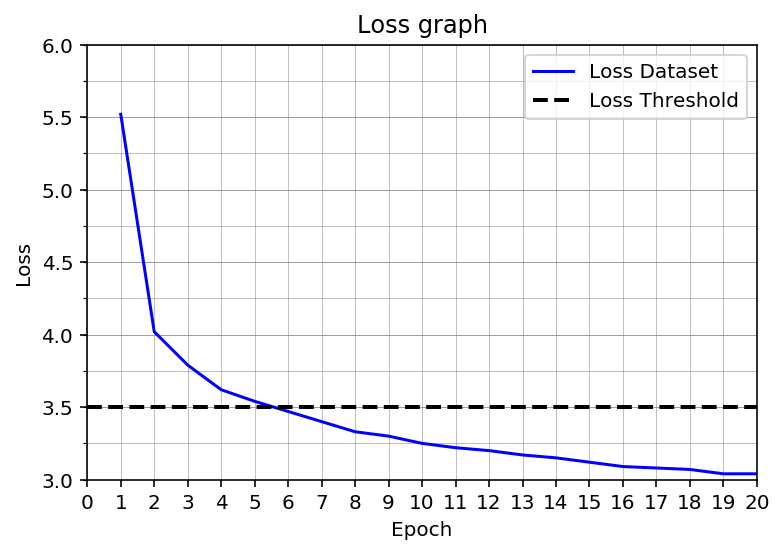

In [16]:
# Represent the training performances:

# Read the data contained in the performance file:

epoch_list = []
loss_list = []

with open('training/training_perf.txt', 'r') as performance_file:
    f_line = performance_file.readline()
    while f_line != "":
        if f_line[0] != "#":
            f_line_l = f_line.strip().split()
            epoch_list.append(int(f_line_l[0]))
            loss_list.append(float(f_line_l[1]))
        f_line = performance_file.readline()

# Define the graph:
fig, ax = plt.subplots()

# Configuration of the graph:
ax.set_title('Loss graph')
ax.plot(epoch_list, loss_list, color='blue', linestyle='solid',\
        label='Loss Dataset')
ax.plot([0, 20], [3.5, 3.5], color='black', linestyle='--',\
        linewidth=2, label='Loss Threshold')
ax.legend()
ax.set_xlim(0, 20)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(21))
ax.grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
ax.set_xlabel('Epoch')
ax.set_ylim(3., 6.)
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(7))
ax.yaxis.set_minor_locator(mpl.ticker.MaxNLocator(13))
ax.grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
ax.grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
ax.set_ylabel('Loss')

# Save the training graph:
fig.savefig('training/training_graph.png')

### *Setting of the hyperparameters*

As it has been specified above, here, we have numerous hyperparameters we can tune to make better our model: In order to leave this notebook clear, I made the decision not to show the different tests that led me to make these choices, nevertheless, below, I will clarify some aspects of my thinking.

As Yoshua Bengio (http://www.iro.umontreal.ca/~bengioy/yoshua_en/index.html) said, the learning rate is the single most important hyperparameter, and one should always make sure it has been tuned. A good starting point is 0.01, and other good options to consider are 0.1, 0.001, 0.0001 or 0.00001. The better results I have obtained have been for a learning rate set to 0.001.

Respect to the sequence length hyperparameter, I have tried length from 10 to 100, and for the hidden dimension hyperparameter, I have tried the values 128, 256 and 512. The smaller these hyperparameters are, the lower the loss generally is, but the longer the training generally is too! To balance that situation, I decided to set the sequence length to 50 and the hidden dimension to 256.

Finally, experience shows that for these types of architecture (RNNs), generally, 2 or 3 layers neural networks allow to achieve good performances, but going even deeper (4, 5, 6... layers) rarely helps much more (which is stark contrast to CNNs, where depth has been found to be an extremely important component for a good recognition system). So, to manage to have good performances and save training time, I have decided to use 2 layers (well, nevertheless, the training has lasted more than 6 hours on GPU mode!).

## Checkpoint: Trained RNN model

After running the above training cell, our model has been saved as `trained_rnn.pth` in the folder `training`.

If we save our notebook progress, we can pause here and come back to this code at another time: Our progress can be resumed by running the next cell!

In [17]:
# Load the preprocessed data and trained RNN model:
int_text, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
trained_rnn = helper.load_model('training/trained_rnn.pth')

## Generate TV Script

With the neural network trained and saved, we are going to use it to generate a new, "fake" Seinfeld TV script in this section.

### *Generate Text*

To generate the text, the neural network needs to start with a single word and repeat its predictions until it reaches a set length. We will be using the `generate` function to do this, it takes a word id to start with, `prime_id`, and generates a set length of text, `predict_len`. Also note that it uses top-k sampling to introduce some randomness in choosing the most likely next word, given an output set of word scores!

In [18]:
# Generate the text:

def generate(rnn, prime_id, int_to_vocab, token_dict, pad_value, predict_len=100):
    """
    Generate text using the neural network
    Parameters
     rnn - the PyTorch module that holds the trained neural network
     prime_id - the word id to start the first prediction
     int_to_vocab - the dictionary of word id keys to word values
     token_dict - the dictionary of puncuation tokens keys to puncuation values
     pad_value - the value used to pad a sequence
     predict_len - the length of text to generate
    Returns
     gen_sentences - the generated text
    """
    
    # Put model in evaluation mode:
    rnn.eval()
    
    # Create a sequence (batch_size=1) with the prime_id:
    current_seq = np.full((1, sequence_length), pad_value)
    current_seq[-1][-1] = prime_id
    predicted = [int_to_vocab[prime_id]]
    
    for _ in range(predict_len):
        if train_on_gpu:
            current_seq = torch.LongTensor(current_seq).cuda()
        else:
            current_seq = torch.LongTensor(current_seq)
        
        # Initialize the hidden state:
        hidden = rnn.init_hidden(current_seq.size(0))
        
        # Get the output of the RNN:
        output, _ = rnn(current_seq, hidden)
        
        # Get the next word probabilities:
        proba = softmax(output, dim=1).data
        if train_on_gpu:
            proba = proba.cpu()
         
        # Use top_k sampling to get the index of the next word:
        top_k = 5
        proba, top_i = proba.topk(top_k)
        top_i = top_i.numpy().squeeze()
        
        # Select the likely next word index with some element of randomness:
        proba = proba.numpy().squeeze()
        word_i = np.random.choice(top_i, p=proba/proba.sum())
        
        # Retrieve that word from the dictionary:
        word = int_to_vocab[word_i]
        predicted.append(word)     
        
        # The generated word becomes the next "current sequence" and the cycle can continue:
        current_seq = np.roll(current_seq, -1, 1)
        current_seq[-1][-1] = word_i
    
    gen_sentences = ' '.join(predicted)
    
    # Replace punctuation tokens:
    for key, token in token_dict.items():
        ending = ' ' if key in ['\n', '(', '"'] else ''
        gen_sentences = gen_sentences.replace(' ' + token.lower(), key)
    gen_sentences = gen_sentences.replace('\n ', '\n')
    gen_sentences = gen_sentences.replace('( ', '(')
    
    # Return all the sentences:
    return gen_sentences

### *Generate a new script*

Now, it's time to generate the text! For this, we have to set `gen_length` to the length of TV script we want to generate and set `prime_word` to one of the following to start the prediction:
- "jerry"
- "elaine"
- "george"
- "kramer"

Jerry | Elaine
- | -
<img src="images/jerry.jpg"> | <img src="images/elaine.jpg">

George | Kramer
- | -
<img src="images/george.jpg"> | <img src="images/kramer.jpg">

*Note Bene:* We can set the prime word to *any word* in our dictionary, but it's best to start with a name for generating a TV script (we can also start with any other names we find in the original text file!).

In [22]:
# Set preferences:
gen_length = 400
prime_word = 'jerry'

# Define word for padding:
pad_word = helper.SPECIAL_WORDS['PADDING']

# Generate a TV script:
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab,
                            token_dict, vocab_to_int[pad_word], gen_length)

# Print the generated TV script:
print(generated_script)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


jerry: i can go to the bathroom.

jerry: you know, you have a good time.

kramer: well, i'm gonna go to the bathroom.

jerry: yeah.

kramer: yeah, but it's a big deal.(sniffs)

jerry: yeah.(to kramer) so i guess you're not getting married.

kramer: well, that's the way i can do, you know, if you're not interested, and i don't know how to do that?

jerry: i don't know what you're going to do.

kramer: oh, no, no, no, no, no, no, no, no, i don't want to see it, you know, the usual. it's a very exciting place, no registration.

george: i think it's sticking.

george: well, i think i have no power.

george: i know. you have to go. you know i don't know, but it's not really funny.(he exits)

george: oh, yeah.

susan: oh, hi.

elaine:(looking at the closed door) what do you mean?

elaine: i think i have a little problem.

george:(looking at the wreck) you have no idea...

george: i don't know if you could.(george nods)

elaine:(looking at the door) oh yeah. yeah, that's right.(he opens the d

### *Save our favorite TV script*

Once we have a script that we like (or find interesting), we can save it to a text file!

In [23]:
# Create folder 'tv_scripts' to store generated tv scripts:
os.mkdir('tv_scripts')

In [24]:
# Save script to a text file:
generated_script_file = open('tv_scripts/generated_tv_script.txt','w')
generated_script_file.write(generated_script)
generated_script_file.close()

## Our generated TV script is not perfect...

It's ok if our generated TV script doesn't make perfect sense, it should look like alternating lines of dialogue, here is one such example of a few generated lines:

>jerry: what about me?
>
>jerry: i don't have to wait.
>
>kramer:(to the sales table)
>
>elaine:(to jerry) hey, look at this, i'm a good doctor.
>
>newman:(to elaine) you think i have no idea of this...
>
>elaine: oh, you better take the phone, and he was a little nervous.
>
>kramer:(to the phone) hey, hey, jerry, i don't want to be a little bit.(to kramer and jerry) you can't.
>
>jerry: oh, yeah. i don't even know, i know.
>
>jerry:(to the phone) oh, i know.
>
>kramer:(laughing) you know...(to jerry) you don't know.

As we can see, there are multiple characters that say (somewhat) complete sentences, but it doesn't have to be perfect! It takes quite a while to get good results, and often, we will have to use a smaller vocabulary (and discard uncommon words), or get more data.

*Nota Bene:* The Seinfeld dataset is about 3.4 MB, which is big enough for our purposes (for script generation, more than 1 MB of text is generally enough).